In [1]:
#important library:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

2024-04-07 03:34:08.219170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 03:34:08.219271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 03:34:08.376469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## load train and test data
# important steps we need:
- augmentation the train and test data for model to avoid the overfitting
- normalize the directories

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
image_size = (224, 224)  # Rescale images to 224x224 pixels
batch_size = 32

# Define paths to the original training and test directories
train_dir = '/kaggle/input/melanoma-cancer-dataset/train'
test_dir = '/kaggle/input/melanoma-cancer-dataset/test'

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_dir)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.3, random_state=42)

# Create directories for training and validation data
train_data_dir = 'path/to/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = 'path/to/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to the corresponding directories
for subdir in subdirectories:
    filenames = os.listdir(os.path.join(train_dir, subdir))
    train_filenames, validation_filenames = train_test_split(filenames, test_size=0.3, random_state=42)

    for filename in train_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(train_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for filename in validation_filenames:
        src = os.path.join(train_dir, subdir, filename)
        dst = os.path.join(validation_data_dir, subdir, filename)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

# Define data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Print the number of samples in each class for training and validation
print("Number of samples in training set:")
print(train_generator.classes)
print("\nNumber of samples in validation set:")
print(validation_generator.classes)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 8315 images belonging to 2 classes.
Found 3564 images belonging to 2 classes.
Number of samples in training set:
[0 0 0 ... 1 1 1]

Number of samples in validation set:
[0 0 0 ... 1 1 1]
Found 2000 images belonging to 2 classes.


- show the images in the train directory:

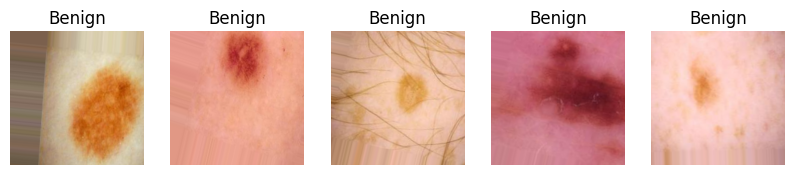

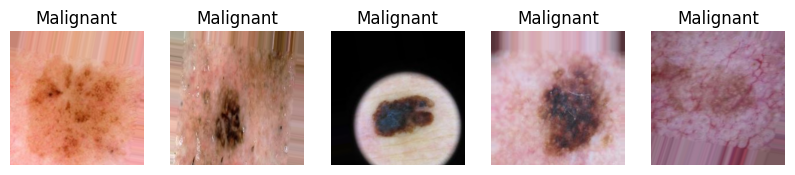

In [3]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = test_generator.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()

- show the images in the test directory:

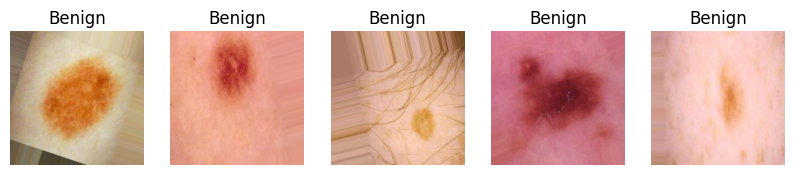

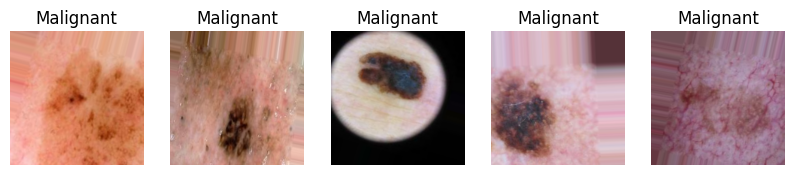

In [4]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = train_generator.class_indices

class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train_generator[0][0], train_generator[0][1]) if label[class_index] == 1][:num_images_per_class]

    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


- build the model:

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization

# Define the input shape
input_shape = (224, 224, 3)

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')
x = base_model.output
BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax', kernel_regularizer=l2(0.001))(x)  # L2 regularization
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


- train the model:

In [6]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history1 = model.fit(train_generator, epochs=15, validation_data=validation_generator)



Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1712461329.482602     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 49/260 ━━━━━━━━━━━━━━━━━━━━ 16:56 5s/step - accuracy: 0.6741 - loss: 1.6304  

W0000 00:00:1712461561.111869     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712461561.385072     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - accuracy: 0.7703 - loss: 1.1063 - val_accuracy: 0.8403 - val_loss: 0.5974
Epoch 2/15
 29/260 ━━━━━━━━━━━━━━━━━━━━ 1:16 330ms/step - accuracy: 0.8502 - loss: 0.5610

W0000 00:00:1712461696.302360     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


 30/260 ━━━━━━━━━━━━━━━━━━━━ 1:16 330ms/step - accuracy: 0.8499 - loss: 0.5606

W0000 00:00:1712461696.631418     108 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 98s 368ms/step - accuracy: 0.8483 - loss: 0.5228 - val_accuracy: 0.8802 - val_loss: 0.4318
Epoch 3/15
 52/260 ━━━━━━━━━━━━━━━━━━━━ 1:08 329ms/step - accuracy: 0.8726 - loss: 0.4275

W0000 00:00:1712461801.905632     108 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


 53/260 ━━━━━━━━━━━━━━━━━━━━ 1:08 329ms/step - accuracy: 0.8726 - loss: 0.4279

W0000 00:00:1712461802.241908     109 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 98s 368ms/step - accuracy: 0.8713 - loss: 0.4379 - val_accuracy: 0.8799 - val_loss: 0.4090
Epoch 4/15
183/260 ━━━━━━━━━━━━━━━━━━━━ 25s 332ms/step - accuracy: 0.8836 - loss: 0.4029

W0000 00:00:1712461987.371554     108 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


184/260 ━━━━━━━━━━━━━━━━━━━━ 25s 332ms/step - accuracy: 0.8836 - loss: 0.4028

W0000 00:00:1712461987.691856     108 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 141s 365ms/step - accuracy: 0.8840 - loss: 0.4006 - val_accuracy: 0.8970 - val_loss: 0.3824
Epoch 5/15
239/260 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.8954 - loss: 0.3743

W0000 00:00:1712462103.849982     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


240/260 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.8954 - loss: 0.3743

W0000 00:00:1712462104.171244     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 98s 367ms/step - accuracy: 0.8954 - loss: 0.3737 - val_accuracy: 0.8956 - val_loss: 0.3792
Epoch 6/15
202/260 ━━━━━━━━━━━━━━━━━━━━ 19s 337ms/step - accuracy: 0.9061 - loss: 0.3479

W0000 00:00:1712462190.396524     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


203/260 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.9060 - loss: 0.3479

W0000 00:00:1712462190.885522     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 371ms/step - accuracy: 0.9044 - loss: 0.3499 - val_accuracy: 0.8993 - val_loss: 0.3727
Epoch 7/15
100/260 ━━━━━━━━━━━━━━━━━━━━ 54s 340ms/step - accuracy: 0.9105 - loss: 0.3150

W0000 00:00:1712462255.054990     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


101/260 ━━━━━━━━━━━━━━━━━━━━ 53s 339ms/step - accuracy: 0.9105 - loss: 0.3151

W0000 00:00:1712462255.366388     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 371ms/step - accuracy: 0.9102 - loss: 0.3207 - val_accuracy: 0.8967 - val_loss: 0.3770
Epoch 8/15
231/260 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.9154 - loss: 0.3128 

W0000 00:00:1712462397.052429     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


232/260 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.9154 - loss: 0.3128

W0000 00:00:1712462397.394875     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 98s 367ms/step - accuracy: 0.9153 - loss: 0.3135 - val_accuracy: 0.8911 - val_loss: 0.3808
Epoch 9/15
 68/260 ━━━━━━━━━━━━━━━━━━━━ 1:03 333ms/step - accuracy: 0.9171 - loss: 0.3014

W0000 00:00:1712462440.544531     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


 69/260 ━━━━━━━━━━━━━━━━━━━━ 1:03 334ms/step - accuracy: 0.9172 - loss: 0.3013

W0000 00:00:1712462440.870299     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 98s 368ms/step - accuracy: 0.9200 - loss: 0.3017 - val_accuracy: 0.9015 - val_loss: 0.3720
Epoch 10/15
 50/260 ━━━━━━━━━━━━━━━━━━━━ 1:09 332ms/step - accuracy: 0.9367 - loss: 0.2682

W0000 00:00:1712462532.609743     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


 51/260 ━━━━━━━━━━━━━━━━━━━━ 1:09 332ms/step - accuracy: 0.9366 - loss: 0.2685

W0000 00:00:1712462532.942087     109 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 371ms/step - accuracy: 0.9277 - loss: 0.2787 - val_accuracy: 0.9024 - val_loss: 0.4092
Epoch 11/15
 98/260 ━━━━━━━━━━━━━━━━━━━━ 54s 338ms/step - accuracy: 0.9315 - loss: 0.2691

W0000 00:00:1712462648.186578     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


 99/260 ━━━━━━━━━━━━━━━━━━━━ 54s 338ms/step - accuracy: 0.9315 - loss: 0.2692

W0000 00:00:1712462648.530090     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 100s 373ms/step - accuracy: 0.9304 - loss: 0.2722 - val_accuracy: 0.9035 - val_loss: 0.4089
Epoch 12/15
116/260 ━━━━━━━━━━━━━━━━━━━━ 49s 340ms/step - accuracy: 0.9396 - loss: 0.2530

W0000 00:00:1712462754.216763     109 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


117/260 ━━━━━━━━━━━━━━━━━━━━ 48s 340ms/step - accuracy: 0.9396 - loss: 0.2530

W0000 00:00:1712462754.546397     108 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 372ms/step - accuracy: 0.9393 - loss: 0.2543 - val_accuracy: 0.9038 - val_loss: 0.3929
Epoch 13/15
233/260 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.9425 - loss: 0.2440

W0000 00:00:1712462892.618345     107 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


234/260 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.9426 - loss: 0.2440

W0000 00:00:1712462892.959953     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 371ms/step - accuracy: 0.9429 - loss: 0.2442 - val_accuracy: 0.9094 - val_loss: 0.3720
Epoch 14/15
227/260 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.9464 - loss: 0.2417

W0000 00:00:1712462989.183710     108 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


228/260 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.9464 - loss: 0.2417

W0000 00:00:1712462989.499865     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 369ms/step - accuracy: 0.9467 - loss: 0.2405 - val_accuracy: 0.9102 - val_loss: 0.3903
Epoch 15/15
 71/260 ━━━━━━━━━━━━━━━━━━━━ 1:02 331ms/step - accuracy: 0.9508 - loss: 0.2362

W0000 00:00:1712463034.978271     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


 72/260 ━━━━━━━━━━━━━━━━━━━━ 1:02 331ms/step - accuracy: 0.9508 - loss: 0.2361

W0000 00:00:1712463035.323096     106 graph_launch.cc:161] Evict all gpu graphs from executor 0x579667f2c040


260/260 ━━━━━━━━━━━━━━━━━━━━ 98s 368ms/step - accuracy: 0.9522 - loss: 0.2254 - val_accuracy: 0.9127 - val_loss: 0.3960


- test the trainable model:

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 747ms/step - accuracy: 0.9537 - loss: 0.2174
Test Accuracy: 0.909500002861023


- plot the loss in each epoch

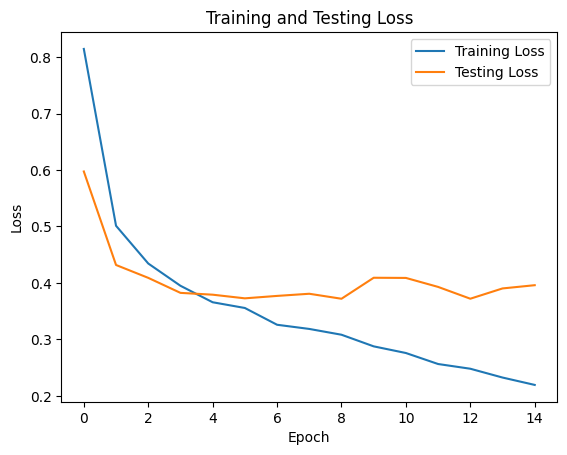

In [8]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()


- plot the accuracy in each epoch

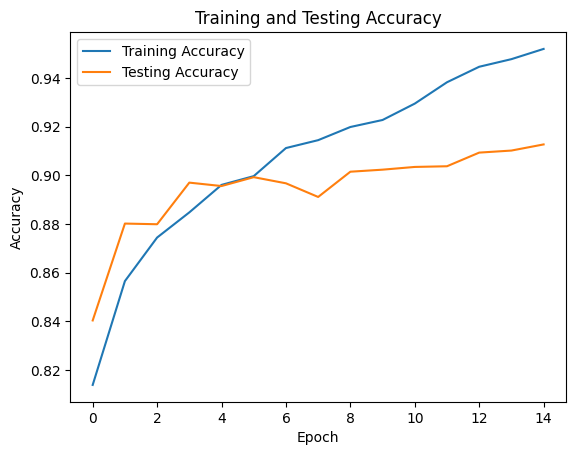

In [9]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

- confusion matric and classification report:

In [10]:
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_generator.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print('----------------------------------------------------------------------------------------------')

class_report = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)


63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 382ms/step
Confusion Matrix:
[[961  39]
 [142 858]]
----------------------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1000
           1       0.96      0.86      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



- plot the confusion matrix
:

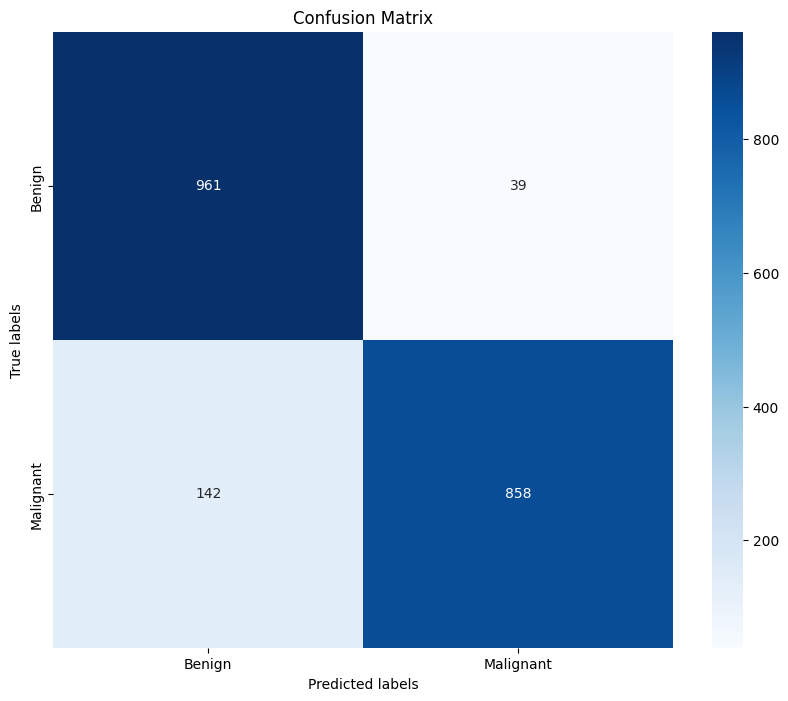

In [11]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()